<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Traffic-forecasting/blob/main/Notebooks/EDA_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Create a text file

In [4]:
!ls "/content/files" >> "/content/file_names.txt" # Create a text file and store all files' names inside

with open('/content/file_names.txt','r') as file: # read this file
    files_names =file.read().splitlines()


print("first name is : ",files_names[0])
print("second name is: ",files_names[1])
print("...")
print("...")
print("...")
print("last name is :",files_names[-1])

first name is :  IntraTM-2005-01-01-00-30.xml
second name is:  IntraTM-2005-01-01-00-45.xml
...
...
...
last name is : IntraTM-2005-01-31-23-45.xml


# extract information from all files using their names

In [10]:
def create_list_of_dfs(files_names):

  """Input: names of files in the dataset folder as a list
     Output: a list of dataframes for all files"""


  dataframe_list =  list()

  for index,file_name in enumerate(tqdm(files_names,"Processing")): # Iterate over files

      df = pd.DataFrame({})
      file_path = '/content/files/'+ file_name

      tree = ET.parse(file_path) # parsing the file
      root = tree.getroot()
      date = file_name.split(".")[0].split("IntraTM-")[1] # extracting only date from file_name
      #eg : file_path="/content/files/IntraTM-2005-01-01-00-30.xml" ,
      #date = 2005-01-01-00-30


      # fixed variables to store values
      src_id_list  = list()
      dst_id_list = list()
      traffic_list =  list()


      for src in root.findall(".//src"):  # finding where we have src in html file
          src_id = src.get('id') #  receive src_id

          for dst in src.findall('dst'): # run a loop for that src to find all destinations
              dst_id = dst.get('id')  # receive dst id
              traffic = dst.text   # dst value

              src_id_list.append(int(src_id)) # store src_id
              dst_id_list.append(int(dst_id)) # store dst_id
              traffic_list.append(float(traffic)) # store traffic

      # add values to the dataframe
      df.insert(loc=0,column="src_id",value=src_id_list)
      df.insert(loc=1,column="dst_id",value=dst_id_list)
      df.insert(loc=2,column=f'{date}',value=traffic_list)

      # add dataframe to a list
      dataframe_list.append(df)

  return dataframe_list


In [11]:
dataframe_list = create_list_of_dfs(files_names)

Processing: 100%|██████████| 2941/2941 [00:07<00:00, 367.84it/s]


In [74]:
number_of_files = len(dataframe_list)
print('Number_of_files:',number_of_files)

Number_of_files: 2941


In [14]:
# Let's see two dataframes
print('First dataframe')
display(dataframe_list[0])
print('Second dataframe')
display(dataframe_list[1])

First dataframe


,src_id,dst_id,2005-01-01-00-30
0,12,12,396708.2311
1,12,13,28093.7511
2,12,19,16916.5600
3,12,23,3662.8089
4,12,8,6552.9333
...,...,...,...
472,15,14,0.4622
473,15,11,496.4711
474,15,9,3781.9644
475,15,17,889.2267


Second dataframe


,src_id,dst_id,2005-01-01-00-45
0,12,12,338875.5644
1,12,13,28485.3422
2,12,19,11769.3422
3,12,23,1950.5067
4,12,8,5445.9111
...,...,...,...
470,15,14,3.1644
471,15,11,493.4844
472,15,9,888.7289
473,15,17,8000.8178


# Merge all dataframes together

In [94]:
# Initialize the merged DataFrame with the first DataFrame in the list
df = dataframe_list[0]

# Iterate over the remaining DataFrames and perform an outer join
for dataframe in tqdm(dataframe_list[1:]):
    df = pd.merge(df, dataframe, on=['src_id', 'dst_id'], how='outer')


#save as a csv file
df.to_csv('df.csv',index=False)

100%|██████████| 2940/2940 [01:14<00:00, 39.21it/s]


# EDA on data

In [155]:
df = pd.read_csv("/content/df.csv")
display(df)

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.2311,338875.5644,341894.5422,347749.5822,320159.4933,336569.9733,304732.9422,318965.9822,...,311502.9422,317854.7644,315334.9156,320295.8133,318063.6711,320748.4711,298609.4489,297175.1556,305258.2222,310534.2756
1,12,13,28093.7511,28485.3422,38402.6756,31250.8356,50818.0000,20076.4000,33443.3600,40365.1111,...,30722.8444,31104.5422,47739.3156,35189.5644,33934.6667,30320.1689,25305.5378,26145.2978,28801.8756,30300.6667
2,12,19,16916.5600,11769.3422,5830.6311,7052.6489,6173.0222,4775.5111,5676.6489,4924.9511,...,3370.6400,1122.3911,1256.7911,2634.7289,3196.2667,4596.8444,7102.2844,5395.0400,4077.1556,10089.4489
3,12,23,3662.8089,1950.5067,2293.3778,1915.7244,1556.5333,1623.6089,1072.9422,855.4222,...,194.0889,726.8267,4217.2444,16669.8222,17209.4222,8732.4267,62.8800,412.2133,166.9067,119.0400
4,12,8,6552.9333,5445.9111,5831.0578,5757.1556,5453.6000,5178.4000,7083.3333,8414.4267,...,2915.8933,2589.1467,4792.2933,4280.5689,3852.2133,2539.4667,2017.9289,1540.2044,1812.3022,1205.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.8178,NaN,NaN,0.8178,NaN,1.6356,0.8178,NaN,0.8178
519,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,20,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
column_names = df.columns
features = column_names[2:]

In [157]:
#change float 64 to 16 for traffic to decrease computation ahead
print("*"*100)
print('Original inforamtion of dataframe:')
print("*"*100)
df.info()
print("*"*100)
print('Updated inforamtion of dataframe with lower memory:')
print("*"*100)
df[features] = df[features].astype(np.float32)
df.info()

****************************************************************************************************
Original inforamtion of dataframe:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float64(2941), int64(2)
memory usage: 11.7 MB
****************************************************************************************************
Updated inforamtion of dataframe with lower memory:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float32(2941), int64(2)
memory usage: 5.9 MB


In [158]:
# Look at self-loop in the dataframe
# print('The following nodes have self_loop to theirselves in several times.')
# self_loop_nodes = np.sort(df[df['src_id']==df['dst_id']]['src_id'].values)
# self_loop_nodes
# Dropping self_loop_nodes
# df.drop(df[df['src_id']==df['dst_id']].index,inplace=True)
#display(df)

In [159]:
nan_counts = df.isnull().sum(axis=1)
nan_counts


0         0
1         0
2         0
3         1
4         0
       ... 
517    2935
518    2821
519    2939
520    2939
521    2939
Length: 522, dtype: int64

In [160]:
index_list_to_remove  = list()
nan_counts_index = nan_counts.index
nan_count_values = nan_counts.values
for nan_value_index,nan_value  in zip(nan_counts_index,nan_count_values):
  if (nan_value/number_of_files)*100 >25:
    index_list_to_remove.append(nan_value_index)

print("This indexes have more nan values, so we need to remove them")
print(index_list_to_remove)

This indexes have more nan values, so we need to remove them
[13, 33, 54, 66, 75, 77, 83, 87, 96, 98, 127, 137, 159, 180, 202, 213, 216, 223, 244, 245, 264, 286, 298, 299, 300, 304, 309, 326, 336, 337, 352, 365, 366, 385, 407, 429, 451, 472, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521]


In [161]:
df.drop(index_list_to_remove,inplace=True)
display(df)

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
1,12,13,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
2,12,19,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
3,12,23,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
4,12,8,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,15,2,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
473,15,11,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
474,15,9,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607
475,15,17,889.226685,8000.817871,3387.182129,544.746704,453.786713,941.253296,4769.849121,5940.586914,...,171.235596,355.911102,450.577789,760.711121,8573.040039,695.128906,689.431091,2366.382080,381.626709,228.142197


In [188]:
df.isnull().sum(axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
471    0
473    0
474    0
475    0
476    0
Length: 439, dtype: int64

In [163]:
df.fillna(axis='index',method="ffill",inplace= True)

In [194]:
df.loc[0][0]

12.0

In [200]:
def plot_graph(dataframe,row):
  fig, ax = plt.subplots(figsize=(12, 8))


  data = dataframe.iloc[row,2:]
  src_id = df.loc[row][0]
  dst_id = df.loc[row][1]
  data.plot(label=f'src_id:{int(src_id)},dst_id:{int(dst_id)}')

  # Define the positions for x-ticks (e.g., every 50th point)
  positions = range(0, len(data), 100)
  # Define the corresponding labels for these positions

  labels = [features[i] for i in positions]

  # Set the positions and labels of the x-ticks
  ax.set_xticks(positions)
  ax.set_xticklabels(labels, rotation=90)  # Rotation to vertical
  plt.legend()
  plt.title("Traffic shown in 1 month")
  # Show the plot
  plt.show()



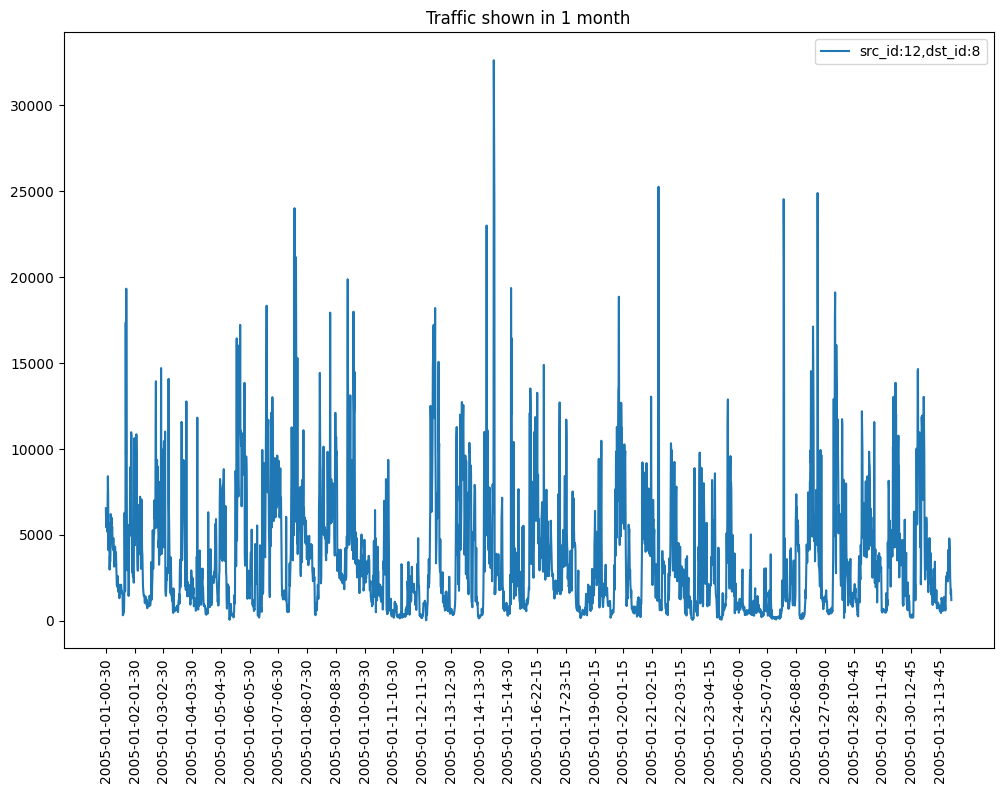

In [207]:
plot_graph(df,4)